<a href="https://colab.research.google.com/github/leabizbille/ProjetIOT/blob/main/AIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
!pip install summarytools -q

In [69]:
!pip install pygwalker -q

In [70]:
pip install sweetviz -q

In [71]:
import pygwalker as pyg
from summarytools import dfSummary # module pandas-profiling
import pandas as pd
import sweetviz as sv # Module pour faire le rapport HTML
import missingno as msno # observer les données manquantes
from google.colab import files # Exporter en cvs

In [72]:
# Charger le fichier CSV en conservant les titres des colonnes
AIH= pd.read_csv("/content/AIH_2024.csv",sep= ";")


<Axes: >

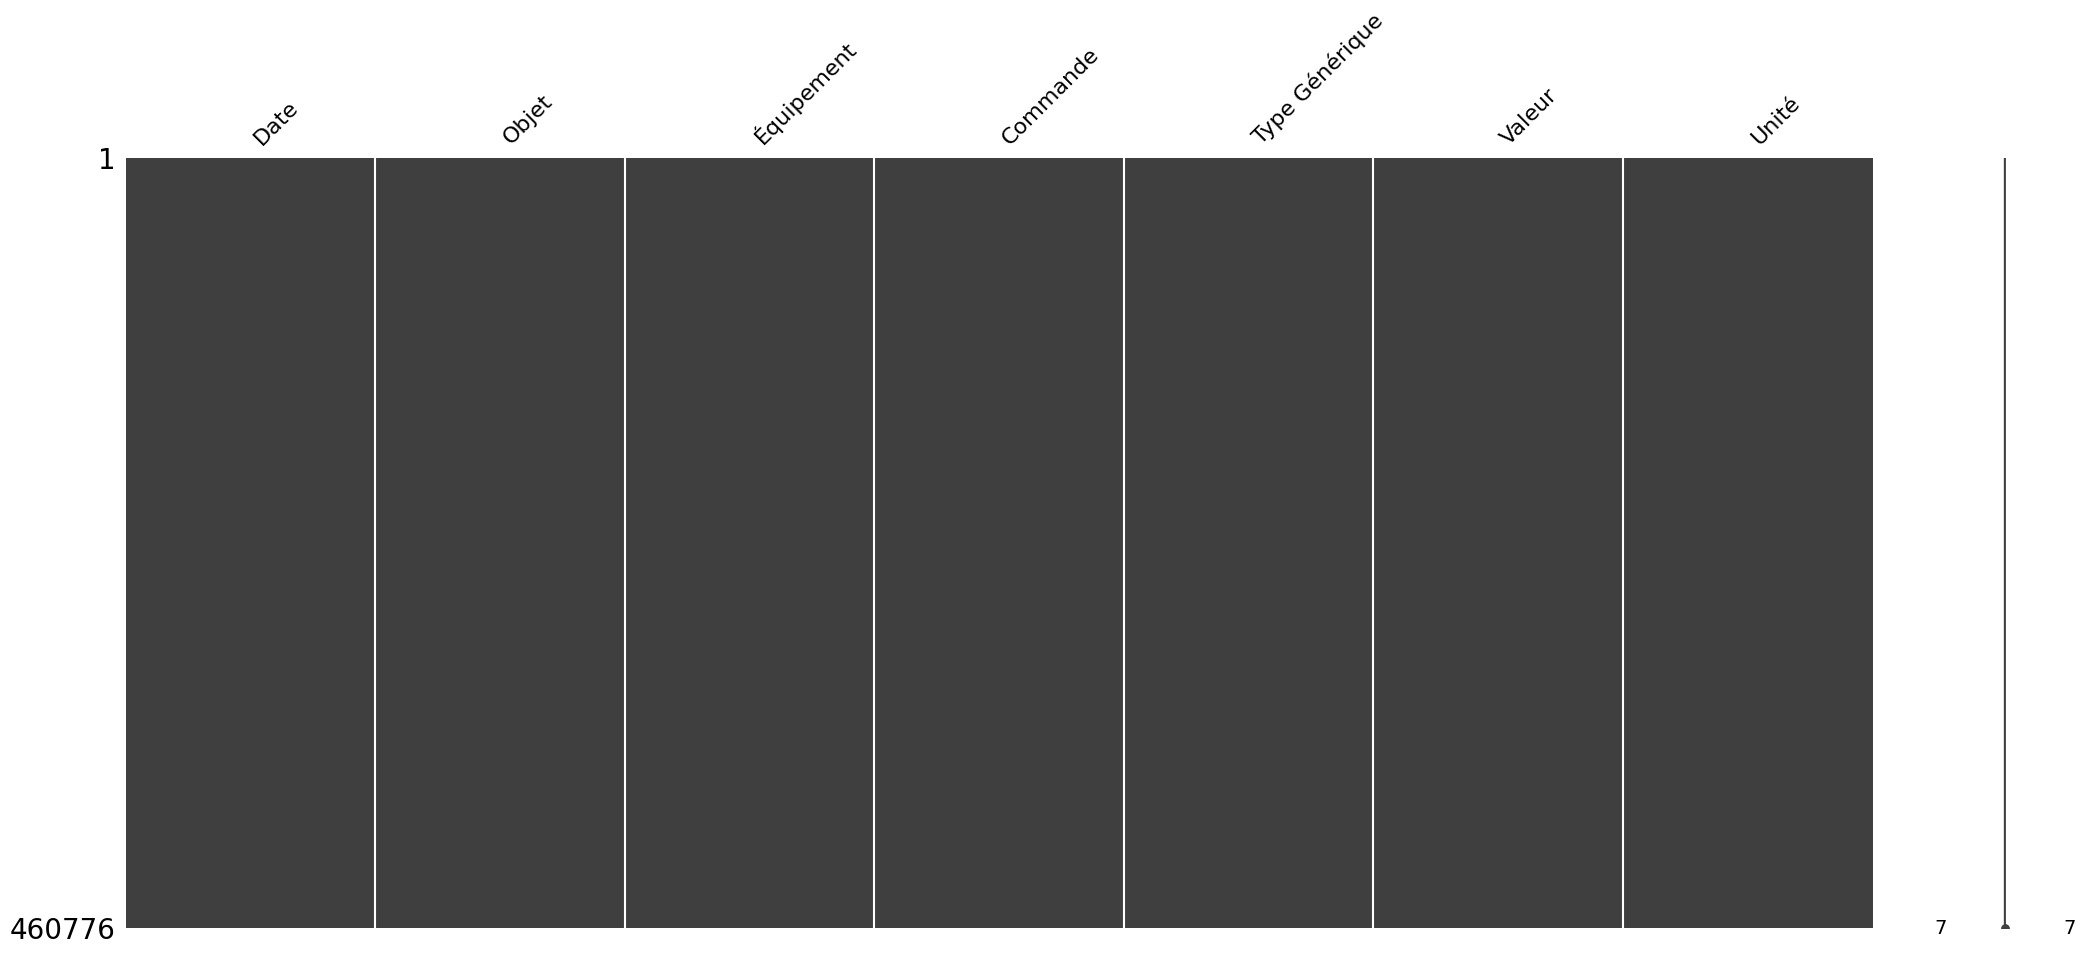

In [73]:
msno.matrix(AIH)

In [74]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(AIH)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2020-08-07 16:40:002. 2021-12-06 14:57:053. 2020-08-07 16:45:004. 2022-09-15 11:00:005. 2021-12-06 14:57:046. 2021-06-05 11:00:007. 2023-08-06 10:00:008. 2023-01-31 13:05:009. 2021-06-01 19:00:0010. 2022-11-21 12:00:0011. other,"6 (0.0%)5 (0.0%)4 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)460,740 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Objet[object],1. Sonde,"460,776 (100.0%)",,0(0.0%)
3,Équipement[object],1. Sonde_A16_SE_892. Sonde_A14_SE_873. Sonde_A13_SW_864. Sonde_A17_SW_805. Sonde_A01_SW_746. Sonde_A08_SW_717. Sonde_D23_SW_968. J6_Sonde extérieure Bat D9. Sonde_A11_SW_8410. Sonde_D25_S+W_9811. other,"49,219 (10.7%)47,767 (10.4%)46,846 (10.2%)46,768 (10.1%)42,019 (9.1%)41,624 (9.0%)40,782 (8.9%)34,567 (7.5%)33,327 (7.2%)28,365 (6.2%)49,492 (10.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD80lEQVR4nO3dQWojRwCG0VIQQ2YjYQw+jA+Rw+YQuo0x1iIzzEZZZBtlurrEF/C8t7fQ4qNEN/27D7fbbUDht//7C/DrEBsZsZERGxmxkREbGbGRERsZsZE5jDG+jjG+LH7Oj9vt9u0B34dP7Pj8/PzH6XR6WvmQ6/X6fjgc/hQc/+V4Op2eXl9fv53P5+97PuDj4+P3y+Xy9Pb29mWMITbuOo4xxvl8/v7y8vLXwud8fdD34RNzgUBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSOY/zzTNreD1j5W34tx+v1+n65XJ7GwjNp1+v1fYzx43Ffi8/IBoHMwb/MovKIk82pxibL6yrLKrZaWldZVjHjEesqyyo2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNLgxdiFGcuDF2MXtvJYOBmDFzJONjIGL2QMXsgYvJBxU5eM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZgxcyHgsnY/BCxgUCGT+jZKyryFhXkbGuIuMCgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjIeCydjXUVm5WRzojFl9+DF0IVZuwYvhi7ssTJ4MXRhipu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZHYNXgxd2GP34MXQhVkeCydj8ELGyUbG4IWMwQsZgxcybuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkbBDIWFeRcbKRsa4iY11FxrqKjJu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kPFYOBmDFzJ7TjYnGrtMD14MXdhravBi6MKKPYMXQxd2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNTgxdCFFdODF0MX9vJYOBmDFzIuEMjM/oz6CWW3qXWVZRUrNq+rLKtYNbuusqxiNxcIZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDavqyyrWDW1rrKsYoXHwslYV5GZOdmcaizZPHgxdmHVpsGLsQuPMDN4MXZhiZu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDYNXoxdeITNgxdjF1Z5LJyMwQuZPS9K+zdOPX5q6g0v9xjDsMXmN7zcYwzDVrNveLnHGIafclOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOY3vNxjDMNWU294uccYhi08Fk7G4IWMCwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJ/A5lrTuIhgNUFAAAAAElFTkSuQmCC"">",0(0.0%)
4,Commande[object],1. Température2. Température 4,"399,307 (86.7%)61,469 (13.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG9

- Enlever la colonne " Type Générique", car l'ensemble des valeurs = "Temperature".

- Enlever la colonne " Objet", car l'ensemble des valeurs = "Sonde".

Pour toutes les colonnes, reformater les données.
Un pivotement ou une transposition du tableau sera probablement nécessaire.

In [75]:
# Séparer la colonne 'datetime' en deux colonnes distinctes
AIH[['date', 'time']] = AIH['Date'].str.split(' ', expand=True)

# Convertir les nouvelles colonnes au format datetime
AIH['date'] = pd.to_datetime(AIH['date'], format='%Y-%m-%d')
AIH['time'] = pd.to_datetime(AIH['time'], format='%H:%M:%S').dt.time

# Supprimer l'ancienne colonne si elle n'est plus nécessaire
AIH= AIH.drop(columns=['Objet'])

In [76]:
# Fonction de nettoyage
def nettoyer_equipement(data):
    if data.startswith('Sonde'):
        # Séparer les parties par "_"
        parts = data.split('_')
        return parts[0], parts[1], parts[2], parts[3] if len(parts) > 3 else None
    elif data.startswith('J'):
        # Séparer les parties par espace pour traiter les cas "J2_Sonde extérieure  Bat A1"
        parts = data.split(' ', 2)
        return parts[0], parts[1] if len(parts) > 1 else None, None, parts[2] if len(parts) > 2 else None
    return None, None, None, None

# Appliquer la fonction à la colonne 'Equipement' et créer les nouvelles colonnes
AIH[['Type', 'Numéro', 'Orientation', 'Réplicat']] = AIH['Équipement'].apply(
    lambda x: pd.Series(nettoyer_equipement(x))
)

In [77]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(AIH)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2020-08-07 16:40:002. 2021-12-06 14:57:053. 2020-08-07 16:45:004. 2022-09-15 11:00:005. 2021-12-06 14:57:046. 2021-06-05 11:00:007. 2023-08-06 10:00:008. 2023-01-31 13:05:009. 2021-06-01 19:00:0010. 2022-11-21 12:00:0011. other,"6 (0.0%)5 (0.0%)4 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)460,740 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Équipement[object],1. Sonde_A16_SE_892. Sonde_A14_SE_873. Sonde_A13_SW_864. Sonde_A17_SW_805. Sonde_A01_SW_746. Sonde_A08_SW_717. Sonde_D23_SW_968. J6_Sonde extérieure Bat D9. Sonde_A11_SW_8410. Sonde_D25_S+W_9811. other,"49,219 (10.7%)47,767 (10.4%)46,846 (10.2%)46,768 (10.1%)42,019 (9.1%)41,624 (9.0%)40,782 (8.9%)34,567 (7.5%)33,327 (7.2%)28,365 (6.2%)49,492 (10.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD80lEQVR4nO3dQWojRwCG0VIQQ2YjYQw+jA+Rw+YQuo0x1iIzzEZZZBtlurrEF/C8t7fQ4qNEN/27D7fbbUDht//7C/DrEBsZsZERGxmxkREbGbGRERsZsZE5jDG+jjG+LH7Oj9vt9u0B34dP7Pj8/PzH6XR6WvmQ6/X6fjgc/hQc/+V4Op2eXl9fv53P5+97PuDj4+P3y+Xy9Pb29mWMITbuOo4xxvl8/v7y8vLXwud8fdD34RNzgUBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSOY/zzTNreD1j5W34tx+v1+n65XJ7GwjNp1+v1fYzx43Ffi8/IBoHMwb/MovKIk82pxibL6yrLKrZaWldZVjHjEesqyyo2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNLgxdiFGcuDF2MXtvJYOBmDFzJONjIGL2QMXsgYvJBxU5eM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZgxcyHgsnY/BCxgUCGT+jZKyryFhXkbGuIuMCgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjIeCydjXUVm5WRzojFl9+DF0IVZuwYvhi7ssTJ4MXRhipu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZHYNXgxd2GP34MXQhVkeCydj8ELGyUbG4IWMwQsZgxcybuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkbBDIWFeRcbKRsa4iY11FxrqKjJu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kPFYOBmDFzJ7TjYnGrtMD14MXdhravBi6MKKPYMXQxd2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNTgxdCFFdODF0MX9vJYOBmDFzIuEMjM/oz6CWW3qXWVZRUrNq+rLKtYNbuusqxiNxcIZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDavqyyrWDW1rrKsYoXHwslYV5GZOdmcaizZPHgxdmHVpsGLsQuPMDN4MXZhiZu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDYNXoxdeITNgxdjF1Z5LJyMwQuZPS9K+zdOPX5q6g0v9xjDsMXmN7zcYwzDVrNveLnHGIafclOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOY3vNxjDMNWU294uccYhi08Fk7G4IWMCwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJ/A5lrTuIhgNUFAAAAAElFTkSuQmCC"">",0(0.0%)
3,Commande[object],1. Température2. Température 4,"399,307 (86.7%)61,469 (13.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOElE

In [78]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = AIH['Type'].unique()

# Afficher les modalités
print(modalites)

['Sonde' 'J2_Sonde' 'J6_Sonde']


In [79]:
# Fonction pour nettoyer la colonne 'Type' et extraire 'Numéro'
def nettoyer_type_et_numero(row):
    if row['Type'].startswith('J'):
        numero, type_equipement = row['Type'].split('_', 1)
        return type_equipement, numero
    return row['Type'], row['Numéro']

# Appliquer la fonction pour mettre à jour 'Type' et 'Numéro'
AIH[['Type', 'Numéro']] = AIH.apply(
    lambda row: pd.Series(nettoyer_type_et_numero(row)), axis=1
)

In [80]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = AIH['Numéro'].unique()

# Afficher les modalités
print(modalites)

['A08' 'A01' 'A03' 'A17' 'A11' 'A13' 'A14' 'D23' 'A16' 'D25' 'J2' 'J6']


In [81]:
# Fonction de nettoyage
def nettoyer_type(data):
    if data.startswith('Sonde'):
        return 'Sonde Intérieur'
    elif data.startswith('J'):
        return 'Sonde Extérieur'
    return data

# Appliquer la fonction de nettoyage à la colonne 'Objets'
AIH['Type'] = AIH['Équipement'].apply(nettoyer_type)


In [82]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = AIH['Orientation'].unique()

# Afficher les modalités
print(modalites)

['SW' 'SE' 'S+W' None]


In [83]:
# Trouver toutes les modalités uniques dans la colonne 'Équipement'
modalites = AIH['Réplicat'].unique()

# Afficher les modalités
print(modalites)

['71' '74' '76' '80' '84' '86' '87' '96' '89' '98' ' Bat A1' ' Bat D']


In [84]:
# Fonction pour déplacer les valeurs "Bat A1" et "Bat D" vers la colonne Orientation
def déplacer_bat_vers_orientation(row):
    if 'Bat' in row['Réplicat']:
        # Si la valeur dans 'Réplicat' contient "Bat", déplacez-la dans 'Orientation'
        row['Orientation'] = row['Réplicat'] if pd.notna(row['Orientation']) else row['Réplicat']
    return row

# Appliquer la fonction à chaque ligne du DataFrame
AIH = AIH.apply(déplacer_bat_vers_orientation, axis=1)


Verification du nombre de valeur NA

In [85]:
print(AIH.isna().sum())

Date              0
Équipement        0
Commande          0
Type Générique    0
Valeur            0
Unité             0
date              0
time              0
Type              0
Numéro            0
Orientation       0
Réplicat          0
dtype: int64


<Axes: >

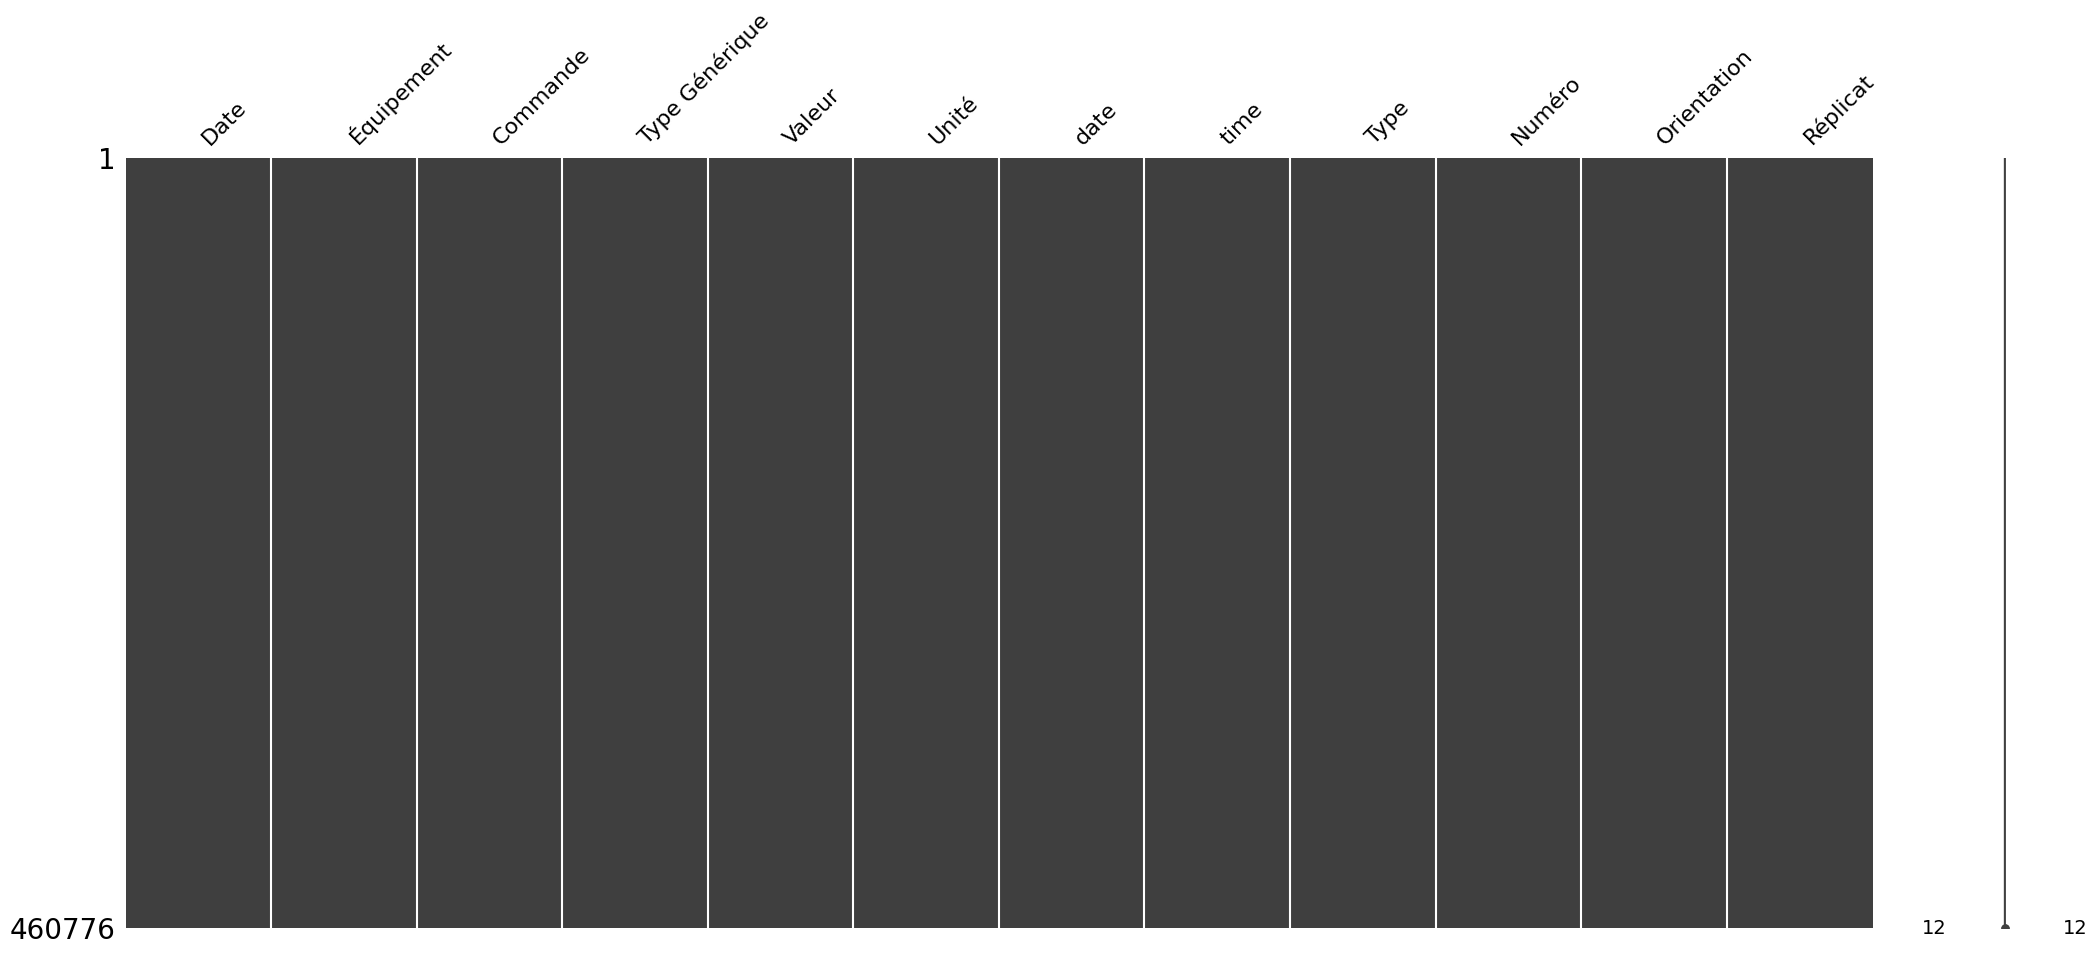

In [86]:
msno.matrix(AIH)

In [87]:
# Description pour comprendre les données et mettre en suite le tableau en forme
dfSummary(AIH)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Date[object],1. 2020-08-07 16:40:002. 2021-12-06 14:57:053. 2020-08-07 16:45:004. 2022-09-15 11:00:005. 2021-12-06 14:57:046. 2021-06-05 11:00:007. 2023-08-06 10:00:008. 2023-01-31 13:05:009. 2021-06-01 19:00:0010. 2022-11-21 12:00:0011. other,"6 (0.0%)5 (0.0%)4 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)3 (0.0%)460,740 (100.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAADLklEQVR4nO3cwY3TYBRG0ecogmFja2QpJUAPKYItvdOFNzCswoIeriVzTgX/4kpPkfxleb1eA4Xb2Q/g/yE2MmIjIzYyYiMjNjJiIyM2MmIjIzYyt2VZvi3L8nb2Q7i+28x8nZnPZz+E63NGyYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3MbWZ+zsyfsx/C9S3+xYiKM0pGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEZGbGSsq8hYV5FxRsmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGYMXMgYvZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyFhXkbGuIuOMkhEbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKBmxkREbGesqMtZVZJxRMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYy1lVkrKvIOKNkxEbG4IWMwQsZZ5SM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmDFzLOKJllZr7MzKezH8L13fd9/76u6/vZD+H67uu6vj+fz9/btn2c/Riu6ziOt/vMzLZtH4/H49fZD+La/EAgIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjc5/59/nH2Q/h2o7jeFv2ff/h40kKPgsnY11Fxg8EMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwFj50uCzHpkKgAAAABJRU5ErkJggg=="">",0(0.0%)
2,Équipement[object],1. Sonde_A16_SE_892. Sonde_A14_SE_873. Sonde_A13_SW_864. Sonde_A17_SW_805. Sonde_A01_SW_746. Sonde_A08_SW_717. Sonde_D23_SW_968. J6_Sonde extérieure Bat D9. Sonde_A11_SW_8410. Sonde_D25_S+W_9811. other,"49,219 (10.7%)47,767 (10.4%)46,846 (10.2%)46,768 (10.1%)42,019 (9.1%)41,624 (9.0%)40,782 (8.9%)34,567 (7.5%)33,327 (7.2%)28,365 (6.2%)49,492 (10.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD80lEQVR4nO3dQWojRwCG0VIQQ2YjYQw+jA+Rw+YQuo0x1iIzzEZZZBtlurrEF/C8t7fQ4qNEN/27D7fbbUDht//7C/DrEBsZsZERGxmxkREbGbGRERsZsZE5jDG+jjG+LH7Oj9vt9u0B34dP7Pj8/PzH6XR6WvmQ6/X6fjgc/hQc/+V4Op2eXl9fv53P5+97PuDj4+P3y+Xy9Pb29mWMITbuOo4xxvl8/v7y8vLXwud8fdD34RNzgUBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGSOY/zzTNreD1j5W34tx+v1+n65XJ7GwjNp1+v1fYzx43Ffi8/IBoHMwb/MovKIk82pxibL6yrLKrZaWldZVjHjEesqyyo2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNLgxdiFGcuDF2MXtvJYOBmDFzJONjIGL2QMXsgYvJBxU5eM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2MwQsZgxcyHgsnY/BCxgUCGT+jZKyryFhXkbGuIuMCgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYx1FRnrKjIeCydjXUVm5WRzojFl9+DF0IVZuwYvhi7ssTJ4MXRhipu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZHYNXgxd2GP34MXQhVkeCydj8ELGyUbG4IWMwQsZgxcybuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERsZ6yoy1lVkbBDIWFeRcbKRsa4iY11FxrqKjJu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kPFYOBmDFzJ7TjYnGrtMD14MXdhravBi6MKKPYMXQxd2cVOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzNTgxdCFFdODF0MX9vJYOBmDFzIuEMjM/oz6CWW3qXWVZRUrNq+rLKtYNbuusqxiNxcIZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDavqyyrWDW1rrKsYoXHwslYV5GZOdmcaizZPHgxdmHVpsGLsQuPMDN4MXZhiZu6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZDYNXoxdeITNgxdjF1Z5LJyMwQuZPS9K+zdOPX5q6g0v9xjDsMXmN7zcYwzDVrNveLnHGIafclOXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzOY3vNxjDMNWU294uccYhi08Fk7G4IWMCwQyYiMjNjJiIyM2MmIjIzYyYiMjNjJ/A5lrTuIhgNUFAAAAAElFTkSuQmCC"">",0(0.0%)
3,Commande[object],1. Température2. Température 4,"399,307 (86.7%)61,469 (13.3%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy81sbWrAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABOElE

In [91]:
# Supprimer l'ancienne colonne si elle n'est plus nécessaire
AIH= AIH.drop(columns=['Type Générique'])

Rapport des données nettoyées :

In [92]:
my_report = sv.analyze(AIH)

                                             |          | [  0%]   00:00 -> (? left)

In [89]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [96]:
AIH['Valeur'] = pd.to_numeric(AIH['Valeur'].str.replace(',', '.'), errors='coerce')

Rapport des données de AIH, binaire entre les SONDES extérieurs et intérieurs

In [97]:
my_report = sv.compare_intra(AIH, AIH["Type"] == "Sonde Intérieur", ["Sonde Intérieur", "Sonde Extérieur"])

                                             |          | [  0%]   00:00 -> (? left)

In [98]:
my_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [101]:

# Sauvegarder le DataFrame en tant que fichier CSV
AIH.to_csv('AIH_export.csv', index=False)

# Télécharger le fichier dans votre machine locale
files.download('AIH_export.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

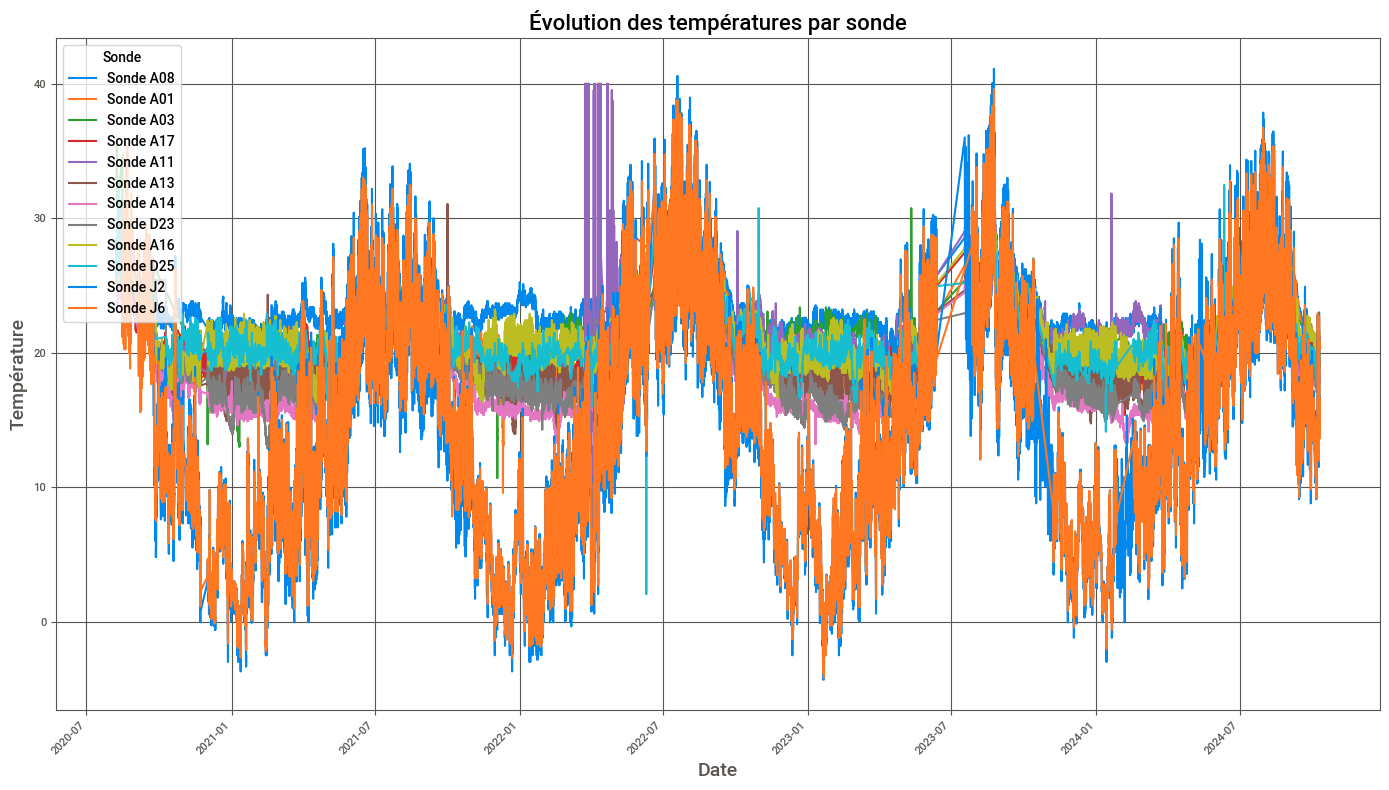

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assurez-vous que la colonne 'Date' est bien au format datetime
AIH['Date'] = pd.to_datetime(AIH['Date'])

# Initialiser le graphique
plt.figure(figsize=(14, 8))

# Tracer une courbe pour chaque sonde
for sonde in AIH['Numéro'].unique():
    # Filtrer les données pour chaque sonde
    sonde_data = AIH[AIH['Numéro'] == sonde]
    plt.plot(sonde_data['Date'], sonde_data['Valeur'], label=f"Sonde {sonde}")

# Ajouter des labels et une légende
plt.title("Évolution des températures par sonde", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Température", fontsize=14)
plt.legend(title="Sonde", loc='upper left', fontsize=10)
plt.grid(True)

# Ajuster les dates pour qu'elles soient lisibles
plt.xticks(rotation=45, ha='right')

# Afficher le graphique
plt.tight_layout()
plt.show()


Pouvez vous certifier que la sonde A11 n'a pas eu de probleme en 2022 en Mars / Avril 2022, car nous avons des temperatures de 40 °C en "hiver".

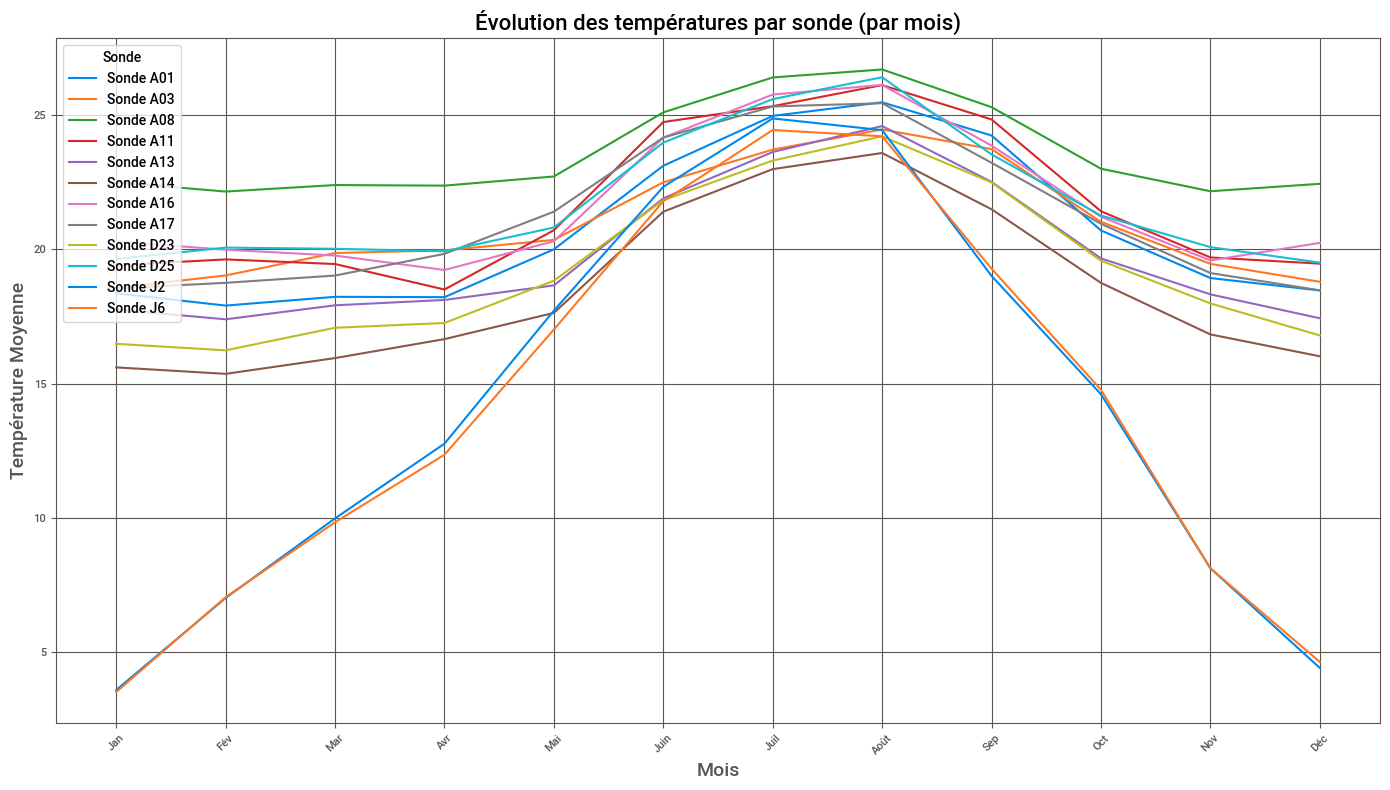

In [109]:

# Ajouter une colonne 'Mois' pour extraire le mois (1-12)
AIH['Mois'] = AIH['Date'].dt.month

# Regrouper les données par mois pour calculer les moyennes mensuelles
moyennes_mensuelles = AIH.groupby(['Mois', 'Numéro'])['Valeur'].mean().reset_index()

# Initialiser le graphique
plt.figure(figsize=(14, 8))

# Tracer une courbe pour chaque sonde
for sonde in moyennes_mensuelles['Numéro'].unique():
    sonde_data = moyennes_mensuelles[moyennes_mensuelles['Numéro'] == sonde]
    plt.plot(sonde_data['Mois'], sonde_data['Valeur'], label=f"Sonde {sonde}")

# Ajouter des labels et une légende
plt.title("Évolution des températures par sonde (par mois)", fontsize=16)
plt.xlabel("Mois", fontsize=14)
plt.ylabel("Température Moyenne", fontsize=14)
plt.xticks(range(1, 13), [
    'Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin',
    'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc'
], rotation=45)
plt.legend(title="Sonde", loc='upper left', fontsize=10)
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()


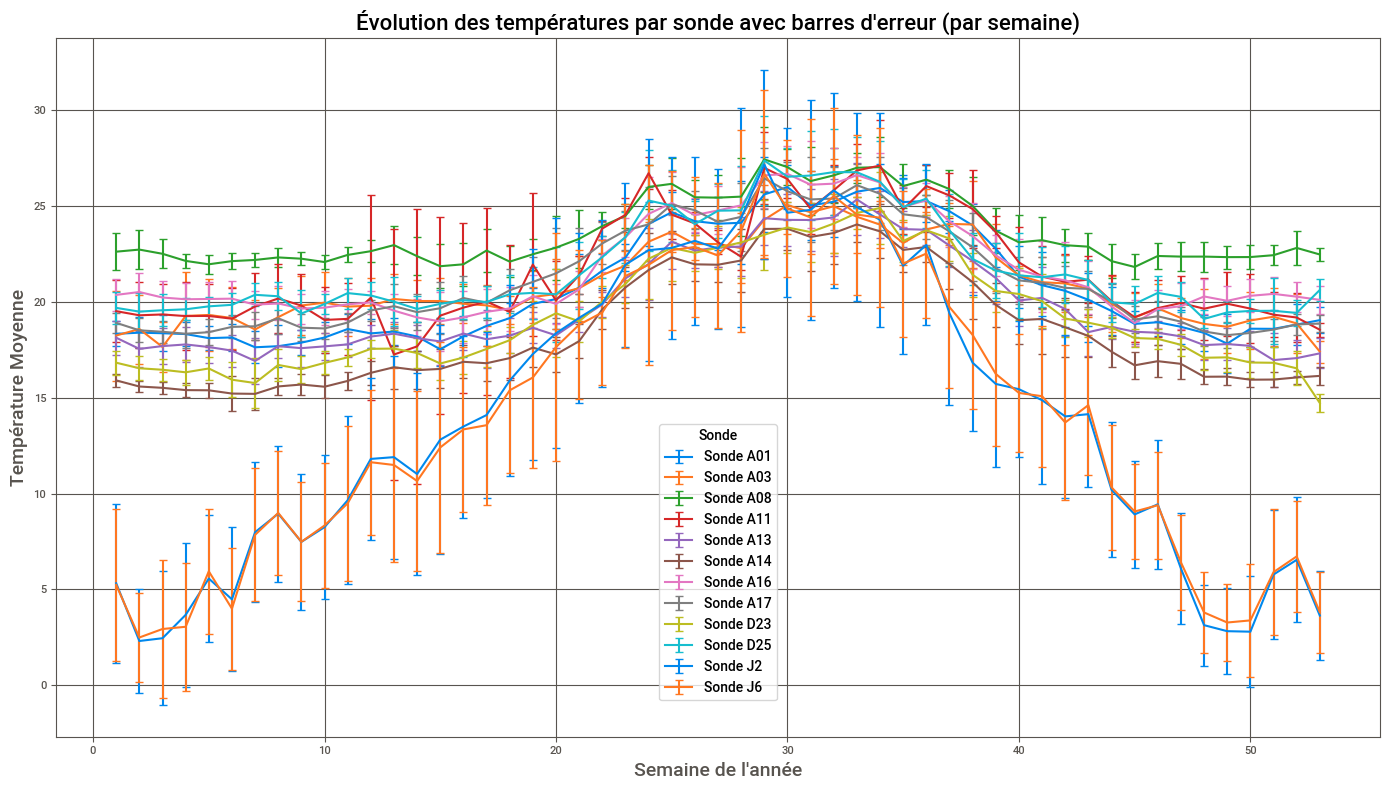

In [117]:
# Ajouter une colonne 'Semaine' pour extraire la semaine de l'année
AIH['Semaine'] = AIH['Date'].dt.isocalendar().week

# Calculer la moyenne et l'écart-type par semaine et par sonde
stats_semaine = AIH.groupby(['Semaine', 'Numéro'])['Valeur'].agg(['mean', 'std']).reset_index()

# Initialiser le graphique
plt.figure(figsize=(14, 8))

# Tracer les courbes avec barres d'erreur
for sonde in stats_semaine['Numéro'].unique():
    sonde_data = stats_semaine[stats_semaine['Numéro'] == sonde]
    plt.errorbar(
        sonde_data['Semaine'],
        sonde_data['mean'],
        yerr=sonde_data['std'],
        label=f"Sonde {sonde}",
        capsize=3
    )

# Ajouter des labels
plt.title("Évolution des températures par sonde avec barres d'erreur (par semaine)", fontsize=16)
plt.xlabel("Semaine de l'année", fontsize=14)
plt.ylabel("Température Moyenne", fontsize=14)

# Positionner la légende au centre en bas
plt.legend(title="Sondes", loc='center', bbox_to_anchor=(0.5, 0.25), fontsize=10)

# Ajouter une grille
plt.grid(True)

# Afficher le graphique
plt.tight_layout()
plt.show()


